<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/master/examples/annotation_types/tiled_imagery_basics.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/master/examples/annotation_types/tiled_imagery_basics.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

## Annotation Types - Tiled Imagery

The tiled imagery annotation type provides a common format between Labelbox and other interfaces. Alongside it comes with some additional features such as:
* Easily access tiled image export data from Labelbox
* Helper functions to transform between Labelbox supported EPSG's 
* Helper function for providing the tiled asset at specific zoom as a numpy array

------- 
## Installation and Imports
* Installing annotation types requires a slightly different pattern
    - `!pip install -q "labelbox[data]"`
* `pip install labelbox` is still valid but it won't add the required dependencies. If you only want the client functionality of the SDK then don't add the [data] extras. However, you will likely get import errors if attempting to use the annotation types

In [1]:
!pip install -q "labelbox[data]"

### Importing modules

In [ ]:
from labelbox.data.annotation_types.data.tiled_image import TiledBounds, TiledImageData, TileLayer, EPSG, EPSGTransformer
from labelbox.data.annotation_types import Point, Polygon, Mask, MaskData, Label
from PIL import Image
import cv2
import numpy as np

## EPSG Class

The EPSG class represents the current supported EPSG's in Labelbox. 

EPSG.SIMPLEPIXEL represents that the tiled image data has bounds in Simple coordinates.

In [2]:
for epsg in EPSG:
    print(epsg)

EPSG.SIMPLEPIXEL
EPSG.EPSG4326
EPSG.EPSG3857


## TiledBounds Class

Bounds are determined by the EPSG and Point objects reflecting top left, and bottom right for a bounding box.

Currently, bounds are only supported in EPSG4326

In [3]:
bounds = TiledBounds(epsg=EPSG.EPSG4326,
                     bounds=[
                         Point(x=-99.21052827588443, y=19.405662413477728),
                         Point(x=-99.20534818927473, y=19.400498983095076)
                     ])

## TileLayer Class

The TileLayer class is the slippy map link to access your data. It can optionally have a name associated with it.

In [4]:
tile_layer = TileLayer(
    url=
    "https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw"
)

## Create TiledImageData

Putting all of the above classes together, we can define a TiledImageData object.

We will need the min and max zoom levels, which are set as a list of integers.

The default tile size is 256, but we can manually set it.

In [5]:
tiled_data = TiledImageData(tile_layer=tile_layer,
                            tile_bounds=bounds,
                            zoom_levels=[15, 20],
                            tile_size=512)

### We can visualize our data within our bounds of interest

Calling TiledImageData.value returns a numpy array based on the minimum zoom level.

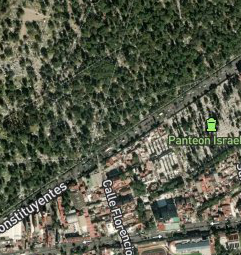

In [6]:
Image.fromarray(tiled_data.value)

If you want to visualize the data at a different zoom level, you can change it using `raster_data(zoom=level)`

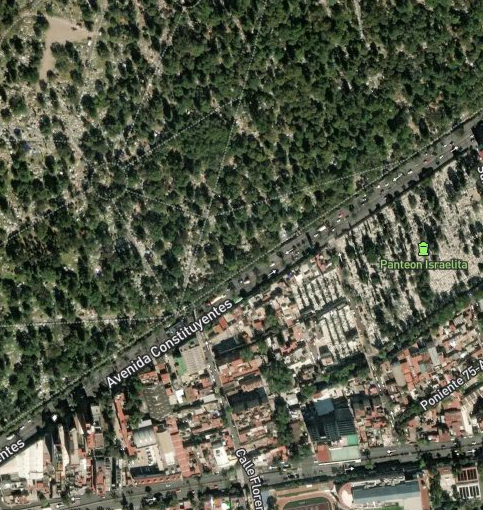

In [8]:
raster_data = tiled_data.raster_data(zoom=16)
Image.fromarray(raster_data.value)

## EPSGTransformer Class

Sometimes, we may be interested in converting from one EPSG to another. This can include Simple coordinates.

To do this, we can create a EPSGTransformer. Depending on the transformation, we will need different parameters.

In [7]:
#our bounds in EPSG4326
[point for point in bounds.bounds]

[Point(extra={}, x=-99.21052827588443, y=19.405662413477728),
 Point(extra={}, x=-99.20534818927473, y=19.400498983095076)]

In [10]:
epsg_4326_to_3857_transformer = EPSGTransformer.create_geo_to_geo_transformer(
    src_epsg=EPSG.EPSG4326, tgt_epsg=EPSG.EPSG3857)

epsg_3857_bounds = epsg_4326_to_3857_transformer(bounds.bounds)
epsg_3857_bounds

[Point(extra={}, x=-11044065.489003124, y=2202754.8028413854),
 Point(extra={}, x=-11043488.844399467, y=2202145.401316802)]

#### We can easily change this back to our previous EPSG's values with an another transformer

In [11]:
epsg_3857_to_4326_transformer = EPSGTransformer.create_geo_to_geo_transformer(
    src_epsg=EPSG.EPSG3857, tgt_epsg=EPSG.EPSG4326)

epsg_4326_bounds = epsg_3857_to_4326_transformer(epsg_3857_bounds)
epsg_4326_bounds

[Point(extra={}, x=-99.21052827588441, y=19.405662413477724),
 Point(extra={}, x=-99.20534818927472, y=19.40049898309508)]

#### EPSG's can also be converted from EPSG Simple, provided two sets of bounds. 

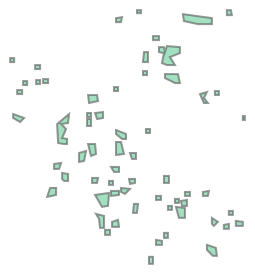

In [12]:
#here we are just providing an example on what annotations may look like
#we will be converting these from Simple to EPSG4326
hsv = cv2.cvtColor(tiled_data.value, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, (50, 10, 25), (100, 150, 255))
Image.fromarray(mask)
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel)
mask = cv2.dilate(mask, kernel)

mask_annotation = MaskData.from_2D_arr(mask)
mask_data = Mask(mask=mask_annotation, color=[255, 255, 255])
pixel_polygons = mask_data.shapely.simplify(3)
pixel_polygons

In [ ]:
#we take the height and width of the cropped image as the pixel bounds
h, w, _ = tiled_data.value.shape
pixel_bounds = TiledBounds(epsg=EPSG.SIMPLEPIXEL,
                           bounds=[Point(x=0, y=0),
                                   Point(x=w, y=h)])

transformer = EPSGTransformer.create_pixel_to_geo_transformer(
    src_epsg=pixel_bounds.epsg,
    pixel_bounds=pixel_bounds,
    geo_bounds=tiled_data.tile_bounds,
    zoom=15)

annotations = [transformer(Polygon.from_shapely(pixel_polygon)) for pixel_polygon in pixel_polygons]

## Visual representation of how these annotations would look laid on top of the original image

![Cat](../assets/ti_basics.png)